In [1]:
# Importation des bibliothèques nécessaires
import os
import glob
import re
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import ConvLSTM2D, Conv2D, Conv3D, MaxPooling2D, MaxPooling3D
from tensorflow.keras.layers import Dense, Flatten, Reshape, TimeDistributed
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
from datetime import datetime
import pickle
import gc  # Garbage Collector

2025-04-30 13:38:55.134341: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1746020335.591183      31 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1746020335.729600      31 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
# Configuration de la précision mixte pour optimiser la mémoire
from tensorflow.keras.mixed_precision import set_global_policy
set_global_policy('mixed_float16')

# Vérification de la disponibilité du GPU
print("GPU disponible:", tf.config.list_physical_devices('GPU'))

GPU disponible: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'), PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU')]


In [3]:
def setup_gpu():
    # Vérifier les GPU disponibles
    gpus = tf.config.list_physical_devices('GPU')
    print(f"GPU disponibles: {len(gpus)}")
    for gpu in gpus:
        print(f" - {gpu}")
    
    if len(gpus) == 0:
        print("Aucun GPU détecté!")
        return None
    
    # Configurer la croissance de mémoire pour éviter d'allouer toute la mémoire immédiatement
    for gpu in gpus:
        try:
            tf.config.experimental.set_memory_growth(gpu, True)
            print(f"Memory growth activé pour {gpu}")
        except RuntimeError as e:
            print(f"Erreur lors de la configuration de la mémoire pour {gpu}: {e}")
    
    # Activer la journalisation des opérations de distribution si nécessaire
    # os.environ["TF_CPP_MIN_LOG_LEVEL"] = "0"
    # tf.debugging.set_log_device_placement(True)
    
    # Créer une stratégie de distribution MirroredStrategy pour utiliser tous les GPU
    strategy = tf.distribute.MirroredStrategy()
    print(f"Nombre de périphériques dans la stratégie: {strategy.num_replicas_in_sync}")
    
    return strategy

In [4]:
strategy = setup_gpu()

GPU disponibles: 2
 - PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')
 - PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU')
Memory growth activé pour PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')
Memory growth activé pour PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU')
Nombre de périphériques dans la stratégie: 2


I0000 00:00:1746020356.175144      31 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1746020356.175894      31 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


In [10]:
#for dirname, _, filenames in os.walk('/kaggle/input'):
    #for filename in filenames:
        #print(os.path.join(dirname, filename))

In [21]:
# Définition des chemins et constantes
DATA_DIR = '/kaggle/input/visualization_outputUp_2019_2024/Rainf'
CHECKPOINT_DIR = '/kaggle/working/Rainf_checkpoints'
MODEL_SAVE_PATH = os.path.join(CHECKPOINT_DIR, 'Rainf_model')
SCALER_SAVE_PATH = os.path.join(CHECKPOINT_DIR, 'Rainf_scaler.pkl')

# Création du répertoire de checkpoint s'il n'existe pas
os.makedirs(CHECKPOINT_DIR, exist_ok=True)

# Paramètres du modèle
SEQUENCE_LENGTH = 30  # Nombre d'images consécutives à utiliser
PREDICTION_STEPS = 7  # Nombre de jours à prédire
IMG_HEIGHT = 128      # Hauteur redimensionnée (réduite pour économiser la mémoire)
IMG_WIDTH = 256       # Largeur redimensionnée
BATCH_SIZE = 32        # Batch size réduit pour économiser la mémoire
EPOCHS = 50           # Nombre d'époques d'entraînement

In [22]:
def extract_date_from_filename(filename):
    """Extraire la date du nom de fichier (ex: Rainf_20190101.png)"""
    pattern = r'Rainf_(\d{8})\.png'
    match = re.search(pattern, os.path.basename(filename))
    if match:
        date_str = match.group(1)
        return datetime.strptime(date_str, '%Y%m%d')
    return None

def optimize_memory():
    """Fonction pour libérer la mémoire"""
    gc.collect()
    tf.keras.backend.clear_session()

In [23]:
def load_and_preprocess_images(data_dir, img_height=128, img_width=256, max_images=None):
    """
    Charger et prétraiter les images avec optimisation de la mémoire
    
    Args:
        data_dir: Répertoire contenant les images
        img_height: Hauteur cible des images redimensionnées
        img_width: Largeur cible des images redimensionnées
        max_images: Nombre maximum d'images à charger (None pour toutes)
        
    Returns:
        X_images: Array numpy des images prétraitées
        dates: Liste des dates correspondantes
    """
    # Récupérer tous les chemins d'images
    image_files = glob.glob(os.path.join(data_dir, 'Rainf_*.png'))
    print(f"Nombre total de fichiers trouvés: {len(image_files)}")
    
    # Limiter le nombre de fichiers si spécifié
    if max_images is not None:
        image_files = image_files[:max_images]
        print(f"Utilisation des {len(image_files)} premiers fichiers")
    
    # Créer une liste de tuples (chemin_fichier, date)
    file_date_pairs = []
    for img_path in image_files:
        date = extract_date_from_filename(img_path)
        if date:
            file_date_pairs.append((img_path, date))
    
    # Trier par date
    file_date_pairs.sort(key=lambda x: x[1])
    print(f"Dates triées: de {file_date_pairs[0][1]} à {file_date_pairs[-1][1]}")
    
    # Charger et prétraiter les images par lots pour économiser la mémoire
    processed_images = []
    dates = []
    
    # Traitement par lots de 100 images
    batch_size = 100
    total_batches = (len(file_date_pairs) + batch_size - 1) // batch_size
    
    for batch_idx in range(total_batches):
        start_idx = batch_idx * batch_size
        end_idx = min((batch_idx + 1) * batch_size, len(file_date_pairs))
        
        print(f"Traitement du lot {batch_idx+1}/{total_batches} ({start_idx}-{end_idx})...")
        
        batch_images = []
        batch_dates = []
        
        for img_path, date in file_date_pairs[start_idx:end_idx]:
            try:
                # Charger l'image avec plt.imread (optimisé pour PNG)
                img = plt.imread(img_path)
                
                # Convertir en niveaux de gris si nécessaire
                if len(img.shape) > 2 and img.shape[2] > 1:
                    img = np.mean(img, axis=2)
                
                # Redimensionner l'image (utiliser une taille plus petite économise la mémoire)
                img = tf.image.resize(img[:,:,np.newaxis], [img_height, img_width]).numpy()
                
                # Ajouter à notre lot
                batch_images.append(img)
                batch_dates.append(date)
                
            except Exception as e:
                print(f"Erreur de chargement de {img_path}: {e}")
        
        # Ajouter le lot traité à nos listes principales
        processed_images.extend(batch_images)
        dates.extend(batch_dates)
        
        # Libérer la mémoire
        gc.collect()
    
    # Convertir en array numpy
    X = np.array(processed_images)
    
    print(f"Forme finale des données: {X.shape}")
    return X, dates

Chargement et prétraitement des images...
Nombre total de fichiers trouvés: 2191
Utilisation des 730 premiers fichiers
Dates triées: de 2019-01-02 00:00:00 à 2024-12-28 00:00:00
Traitement du lot 1/8 (0-100)...
Traitement du lot 2/8 (100-200)...
Traitement du lot 3/8 (200-300)...
Traitement du lot 4/8 (300-400)...
Traitement du lot 5/8 (400-500)...
Traitement du lot 6/8 (500-600)...
Traitement du lot 7/8 (600-700)...
Traitement du lot 8/8 (700-730)...
Forme finale des données: (730, 128, 256, 1)
Nombre d'images chargées: 730
Forme des images: (730, 128, 256, 1)
Première date: 2019-01-02 00:00:00
Dernière date: 2024-12-28 00:00:00


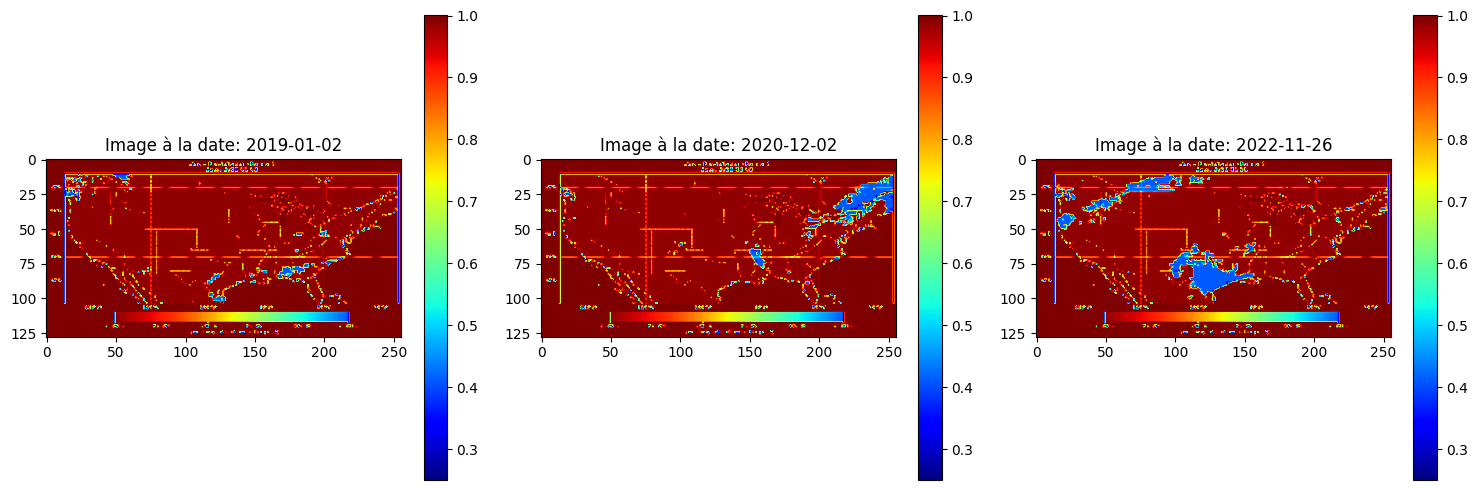

In [24]:
# Exécuter le chargement des données
print("Chargement et prétraitement des images...")
X_images, dates = load_and_preprocess_images(
    DATA_DIR, 
    img_height=IMG_HEIGHT, 
    img_width=IMG_WIDTH,
    max_images=730  # Environ 2 ans de données - ajustez selon vos besoins
)

# Afficher quelques informations
print(f"Nombre d'images chargées: {len(X_images)}")
print(f"Forme des images: {X_images.shape}")
print(f"Première date: {dates[0]}")
print(f"Dernière date: {dates[-1]}")

# Visualiser quelques exemples d'images
plt.figure(figsize=(15, 5))
for i in range(3):  # Afficher 3 images
    idx = i * (len(X_images) // 3)  # Prendre des images réparties uniformément
    plt.subplot(1, 3, i+1)
    plt.imshow(X_images[idx, :, :, 0], cmap='jet')
    plt.title(f"Image à la date: {dates[idx].strftime('%Y-%m-%d')}")
    plt.colorbar()
plt.tight_layout()
plt.show()

# Libérer de la mémoire
optimize_memory()

Normalisation des données...
Scaler sauvegardé à: /kaggle/working/Rainf_checkpoints/Rainf_scaler.pkl
Valeur minimale après normalisation: 0.0
Valeur maximale après normalisation: 1.0000004768371582


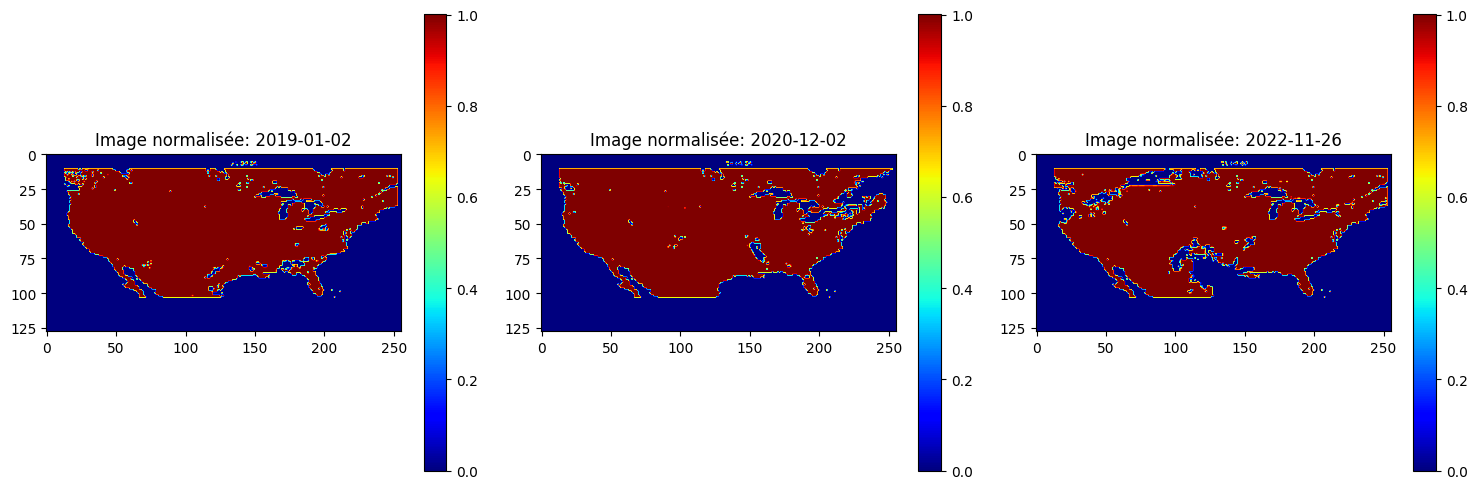

In [25]:
# Normalisation des données
print("Normalisation des données...")
scaler = MinMaxScaler(feature_range=(0, 1))

# Redimensionner pour appliquer le scaler
X_reshaped = X_images.reshape(X_images.shape[0], -1)
X_scaled = scaler.fit_transform(X_reshaped)
X_images_scaled = X_scaled.reshape(X_images.shape)

# Sauvegarde du scaler pour une utilisation ultérieure
with open(SCALER_SAVE_PATH, 'wb') as f:
    pickle.dump(scaler, f)

print(f"Scaler sauvegardé à: {SCALER_SAVE_PATH}")

# Vérifier les valeurs min/max après normalisation
print(f"Valeur minimale après normalisation: {np.min(X_images_scaled)}")
print(f"Valeur maximale après normalisation: {np.max(X_images_scaled)}")

# Visualiser quelques exemples d'images normalisées
plt.figure(figsize=(15, 5))
for i in range(3):
    idx = i * (len(X_images) // 3)
    plt.subplot(1, 3, i+1)
    plt.imshow(X_images_scaled[idx, :, :, 0], cmap='jet')
    plt.title(f"Image normalisée: {dates[idx].strftime('%Y-%m-%d')}")
    plt.colorbar()
plt.tight_layout()
plt.show()

In [26]:
def date_to_features(date_obj):
    """Convertit une date en caractéristiques temporelles utilisables par le modèle"""
    # Vérifier si l'entrée est déjà un objet datetime
    if isinstance(date_obj, str):
        date = datetime.strptime(date_obj, '%Y-%m-%d')
    else:
        # Si c'est déjà un objet datetime, l'utiliser directement
        date = date_obj
    
    # Extraire les caractéristiques temporelles
    year = date.year
    month = date.month
    day = date.day
    day_of_year = date.timetuple().tm_yday
    
    # Caractéristiques cycliques pour le mois et le jour de l'année
    month_sin = np.sin(2 * np.pi * month / 12)
    month_cos = np.cos(2 * np.pi * month / 12)
    day_sin = np.sin(2 * np.pi * day_of_year / 365)
    day_cos = np.cos(2 * np.pi * day_of_year / 365)
    
    return np.array([year, month, day, day_of_year, month_sin, month_cos, day_sin, day_cos])

def create_sequences_with_dates(data, dates, seq_length=30, pred_steps=7, batch_size=100):
    """
    Créer des séquences pour l'entraînement de séries temporelles avec caractéristiques de date
    Utilise le traitement par lots pour économiser la mémoire
    
    Args:
        data: Array numpy des images prétraitées
        dates: Liste des dates correspondantes
        seq_length: Longueur de la séquence d'entrée
        pred_steps: Nombre de pas de temps à prédire
        batch_size: Taille des lots pour économiser la mémoire
        
    Returns:
        X: Séquences d'entrée
        y: Séquences cibles (à prédire)
        date_features: Caractéristiques de date pour chaque séquence
    """
    total_sequences = len(data) - seq_length - pred_steps + 1
    print(f"Création de {total_sequences} séquences au total...")
    
    # Préallouer les tableaux pour économiser de la mémoire
    X = np.zeros((total_sequences, seq_length, *data.shape[1:]), dtype=np.float32)
    y = np.zeros((total_sequences, pred_steps, *data.shape[1:]), dtype=np.float32)
    date_features = np.zeros((total_sequences, 8), dtype=np.float32)  # 8 caractéristiques de date
    
    # Traitement par lots pour économiser la mémoire
    for start_idx in range(0, total_sequences, batch_size):
        end_idx = min(start_idx + batch_size, total_sequences)
        print(f"Traitement des séquences {start_idx} à {end_idx}...", end="\r")
        
        for i in range(start_idx, end_idx):
            # Séquence d'entrée: seq_length images consécutives
            X[i] = data[i:i+seq_length]
            # Séquence cible: pred_steps images suivantes
            y[i] = data[i+seq_length:i+seq_length+pred_steps]
            # Caractéristiques de date pour la dernière date de la séquence d'entrée
            last_date = dates[i+seq_length-1]
            date_features[i] = date_to_features(last_date)
        
        # Libérer la mémoire régulièrement
        if (end_idx - start_idx) % (batch_size * 5) == 0:
            gc.collect()
    
    print(f"\nNombre de séquences créées: {total_sequences}")
    
    
    return X, y, date_features



In [27]:
# Création des séquences avec caractéristiques de date
print("Création des séquences d'entraînement avec caractéristiques de date...")
X_seq, y_seq, date_features = create_sequences_with_dates(
    X_images_scaled, dates, SEQUENCE_LENGTH, PREDICTION_STEPS)

# Afficher les dimensions
print(f"Forme des séquences X: {X_seq.shape}")
print(f"Forme des séquences y: {y_seq.shape}")
print(f"Forme des caractéristiques de date: {date_features.shape}")

# Libérer de la mémoire
try:
    del X_images, X_reshaped, X_scaled
except NameError:
    print("Certaines variables à supprimer n'existent pas, poursuite du processus...")
optimize_memory()
optimize_memory()

# Division en ensembles d'entraînement et de validation (80/20)
split_idx = int(len(X_seq) * 0.8)
X_train, X_val = X_seq[:split_idx], X_seq[split_idx:]
y_train, y_val = y_seq[:split_idx], y_seq[split_idx:]
date_features_train, date_features_val = date_features[:split_idx], date_features[split_idx:]

print(f"Ensemble d'entraînement: {X_train.shape[0]} séquences")
print(f"Ensemble de validation: {X_val.shape[0]} séquences")

# Libérer encore de la mémoire
try:
    del X_images, X_reshaped, X_scaled
except NameError:
    print("Certaines variables à supprimer n'existent pas, poursuite du processus...")
optimize_memory()

# Afficher quelques statistiques sur les caractéristiques de date
print("\nStatistiques des caractéristiques de date (ensemble d'entraînement):")
print(f"Années: min={date_features_train[:, 0].min()}, max={date_features_train[:, 0].max()}")
print(f"Mois: min={date_features_train[:, 1].min()}, max={date_features_train[:, 1].max()}")

Création des séquences d'entraînement avec caractéristiques de date...
Création de 694 séquences au total...
Traitement des séquences 600 à 694...
Nombre de séquences créées: 694
Forme des séquences X: (694, 30, 128, 256, 1)
Forme des séquences y: (694, 7, 128, 256, 1)
Forme des caractéristiques de date: (694, 8)
Ensemble d'entraînement: 555 séquences
Ensemble de validation: 139 séquences
Certaines variables à supprimer n'existent pas, poursuite du processus...

Statistiques des caractéristiques de date (ensemble d'entraînement):
Années: min=2019.0, max=2023.0
Mois: min=1.0, max=12.0


In [28]:
from tensorflow.keras.layers import Input, TimeDistributed, AveragePooling2D, UpSampling2D, Dropout
from tensorflow.keras.models import Model
import gc

# Fonction pour libérer la mémoire
def optimize_memory():
    gc.collect()
    tf.keras.backend.clear_session()

# Activer la précision mixte pour économiser de la mémoire
try:
    from tensorflow.keras import mixed_precision
    policy = mixed_precision.Policy('mixed_float16')
    mixed_precision.set_global_policy(policy)
    print("Mixed precision activée (float16)")
except:
    print("Mixed precision non disponible")

def build_convlstm_model_with_dates_lightweight(seq_length, img_height, img_width, pred_steps, date_features_size):
    """Version allégée du modèle ConvLSTM"""
    # Entrées
    input_sequence = Input(shape=(seq_length, img_height, img_width, 1), name='sequence_input')
    input_date = Input(shape=(date_features_size,), name='date_input')
    
    # Réduire la résolution spatiale pour économiser la mémoire
    x = TimeDistributed(AveragePooling2D(pool_size=(2, 2)))(input_sequence)  # Réduit de moitié
    
    # Utiliser moins de filtres
    x = ConvLSTM2D(filters=32, kernel_size=(3, 3), padding='same', 
                  return_sequences=True, activation='relu')(x)
    
    x = ConvLSTM2D(filters=32, kernel_size=(3, 3), padding='same', 
                  return_sequences=False, activation='relu')(x)
    
    # Aplatir
    x = Flatten()(x)
    
    # Traitement des dates avec moins de neurones
    date_features = Dense(16, activation='relu')(input_date)
    x = tf.keras.layers.Concatenate()([x, date_features])
    
    # Couches denses plus petites
    x = Dense(256, activation='relu')(x)  # Réduit de 1024 à 256
    x = Dropout(0.3)(x)  # Ajouter du dropout pour la régularisation
    
    # Couche finale avec dimensionnalité réduite (moitié de la résolution)
    reduced_height = img_height // 2
    reduced_width = img_width // 2
    x = Dense(reduced_height * reduced_width * pred_steps, activation='linear')(x)
    
    # Reshape pour obtenir la sortie de prédiction
    output = Reshape((pred_steps, reduced_height, reduced_width, 1))(x)
    
    # Restaurer la résolution d'origine
    output = TimeDistributed(UpSampling2D(size=(2, 2)))(output)
    
    model = Model(inputs=[input_sequence, input_date], outputs=output)
    
    # Utiliser un optimizer avec moins de mémoire
    optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
    
    model.compile(
        optimizer=optimizer,
        loss='mse',
        metrics=['mae']
    )
    return model

Mixed precision activée (float16)


In [29]:
# Réduire la taille du batch
BATCH_SIZE = 4  # Utiliser une valeur très petite

# Libérer la mémoire avant de créer le modèle
optimize_memory()
with strategy.scope():
    # Créer le modèle ConvLSTM léger avec prise en compte des dates
    print("Création du modèle ConvLSTM léger avec dates...")
    convlstm_model = build_convlstm_model_with_dates_lightweight(
        SEQUENCE_LENGTH, IMG_HEIGHT, IMG_WIDTH, PREDICTION_STEPS, date_features_train.shape[1])
    convlstm_model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
        loss='mse',
        metrics=['mae']
    )
    callbacks = [
    EarlyStopping(monitor='val_loss', patience=5, verbose=1, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, verbose=1),
    ModelCheckpoint(
        filepath=os.path.join(CHECKPOINT_DIR, 'PotEvap_convlstm_best.keras'),
        monitor='val_loss',
        save_best_only=True,
        verbose=1
    )
    ]

    # Entraînement du modèle avec un batch size très petit et les caractéristiques de date
    print("Entraînement du modèle ConvLSTM...")
    convlstm_history = convlstm_model.fit(
        [X_train, date_features_train], y_train,
        validation_data=([X_val, date_features_val], y_val),
        epochs=EPOCHS,
        batch_size=BATCH_SIZE,
        callbacks=callbacks,
        verbose=1
)
convlstm_model.summary()

Création du modèle ConvLSTM léger avec dates...
Entraînement du modèle ConvLSTM...
Epoch 1/50


E0000 00:00:1746020762.377110      31 meta_optimizer.cc:966] layout failed: INVALID_ARGUMENT: MutableGraphView::SortTopologically error: detected edge(s) creating cycle(s) {'StatefulPartitionedCall/replica_1/functional_1/conv_lstm2d_1/while/body/_913/replica_1/functional_1/conv_lstm2d_1/while/conv_lstm_cell_1/Sigmoid_2' -> 'StatefulPartitionedCall/replica_1/functional_1/conv_lstm2d_1/while/body/_913/replica_1/functional_1/conv_lstm2d_1/while/conv_lstm_cell_1/mul_2', 'StatefulPartitionedCall/replica_1/functional_1/conv_lstm2d_1/while/body/_913/replica_1/functional_1/conv_lstm2d_1/while/conv_lstm_cell_1/Sigmoid' -> 'StatefulPartitionedCall/replica_1/functional_1/conv_lstm2d_1/while/body/_913/replica_1/functional_1/conv_lstm2d_1/while/conv_lstm_cell_1/mul_1', 'StatefulPartitionedCall/replica_1/functional_1/conv_lstm2d_1/while/body/_913/replica_1/functional_1/conv_lstm2d_1/while/conv_lstm_cell_1/convolution_6' -> 'StatefulPartitionedCall/replica_1/functional_1/conv_lstm2d_1/while/body/_913

139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 428ms/step - loss: 0.2255 - mae: 0.3020

E0000 00:00:1746020834.632739      31 meta_optimizer.cc:966] layout failed: INVALID_ARGUMENT: MutableGraphView::SortTopologically error: detected edge(s) creating cycle(s) {'replica_1/functional_1/conv_lstm2d_1/while/body/_103/replica_1/functional_1/conv_lstm2d_1/while/conv_lstm_cell_1/Sigmoid' -> 'replica_1/functional_1/conv_lstm2d_1/while/body/_103/replica_1/functional_1/conv_lstm2d_1/while/conv_lstm_cell_1/mul_1', 'replica_1/functional_1/conv_lstm2d_1/while/body/_103/replica_1/functional_1/conv_lstm2d_1/while/conv_lstm_cell_1/mul' -> 'replica_1/functional_1/conv_lstm2d_1/while/body/_103/replica_1/functional_1/conv_lstm2d_1/while/conv_lstm_cell_1/add_7', 'replica_1/functional_1/conv_lstm2d_1/while/body/_103/replica_1/functional_1/conv_lstm2d_1/while/conv_lstm_cell_1/Sigmoid_2' -> 'replica_1/functional_1/conv_lstm2d_1/while/body/_103/replica_1/functional_1/conv_lstm2d_1/while/conv_lstm_cell_1/mul_2', 'replica_1/functional_1/conv_lstm2d_1/while/body/_103/replica_1/functional_1/conv_lst


Epoch 1: val_loss improved from inf to 0.09152, saving model to /kaggle/working/Rainf_checkpoints/PotEvap_convlstm_best.keras
139/139 ━━━━━━━━━━━━━━━━━━━━ 89s 533ms/step - loss: 0.2250 - mae: 0.3016 - val_loss: 0.0915 - val_mae: 0.2121 - learning_rate: 0.0010
Epoch 2/50
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 429ms/step - loss: 0.1572 - mae: 0.2127
Epoch 2: val_loss improved from 0.09152 to 0.07719, saving model to /kaggle/working/Rainf_checkpoints/PotEvap_convlstm_best.keras
139/139 ━━━━━━━━━━━━━━━━━━━━ 69s 498ms/step - loss: 0.1572 - mae: 0.2127 - val_loss: 0.0772 - val_mae: 0.1878 - learning_rate: 0.0010
Epoch 3/50
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 428ms/step - loss: 0.1454 - mae: 0.2103
Epoch 3: val_loss improved from 0.07719 to 0.07365, saving model to /kaggle/working/Rainf_checkpoints/PotEvap_convlstm_best.keras
139/139 ━━━━━━━━━━━━━━━━━━━━ 69s 496ms/step - loss: 0.1454 - mae: 0.2103 - val_loss: 0.0737 - val_mae: 0.1816 - learning_rate: 0.0010
Epoch 4/50
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 42

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ sequence_input            │ (None, 30, 128, 256,   │              0 │ -                      │
│ (InputLayer)              │ 1)                     │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ time_distributed          │ (None, 30, 64, 128, 1) │              0 │ sequence_input[0][0]   │
│ (TimeDistributed)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv_lstm2d (ConvLSTM2D)  │ (None, 30, 64, 128,    │         38,144 │ time_distributed[0][0] │
│                           │ 32)                    │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv_lstm2d_1             │ (None, 64, 128, 32)    │         73,856 │ conv_lstm2d[0][0]      │
│ (ConvLSTM2D)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ date_input (InputLayer)   │ (None, 8)              │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ flatten (Flatten)         │ (None, 262144)         │              0 │ conv_lstm2d_1[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense (Dense)             │ (None, 16)             │            144 │ date_input[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate (Concatenate) │ (None, 262160)         │              0 │ flatten[0][0],         │
│                           │                        │                │ dense[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_1 (Dense)           │ (None, 256)            │     67,113,216 │ concatenate[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout (Dropout)         │ (None, 256)            │              0 │ dense_1[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_2 (Dense)           │ (None, 57344)          │     14,737,408 │ dropout[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ reshape (Reshape)         │ (None, 7, 64, 128, 1)  │              0 │ dense_2[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ time_distributed_1        │ (None, 7, 128, 256, 1) │              0 │ reshape[0][0]          │
│ (TimeDistributed)         │                        │                │                        │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 245,888,306 (937.99 MB)

 Trainable params: 81,962,768 (312.66 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 163,925,538 (625.33 MB)

Évaluation du modèle ConvLSTM...


E0000 00:00:1746022928.011744      31 meta_optimizer.cc:966] layout failed: INVALID_ARGUMENT: MutableGraphView::SortTopologically error: detected edge(s) creating cycle(s) {'replica_1/functional_1/conv_lstm2d_1/while/body/_103/replica_1/functional_1/conv_lstm2d_1/while/conv_lstm_cell_1/mul' -> 'replica_1/functional_1/conv_lstm2d_1/while/body/_103/replica_1/functional_1/conv_lstm2d_1/while/conv_lstm_cell_1/add_7', 'replica_1/functional_1/conv_lstm2d_1/while/body/_103/replica_1/functional_1/conv_lstm2d_1/while/conv_lstm_cell_1/Sigmoid' -> 'replica_1/functional_1/conv_lstm2d_1/while/body/_103/replica_1/functional_1/conv_lstm2d_1/while/conv_lstm_cell_1/mul_1', 'replica_1/functional_1/conv_lstm2d_1/while/body/_103/replica_1/functional_1/conv_lstm2d_1/while/conv_lstm_cell_1/convolution_6' -> 'replica_1/functional_1/conv_lstm2d_1/while/body/_103/replica_1/functional_1/conv_lstm2d_1/while/conv_lstm_cell_1/add_6', 'replica_1/functional_1/conv_lstm2d_1/while/body/_103/replica_1/functional_1/conv

35/35 ━━━━━━━━━━━━━━━━━━━━ 6s 98ms/step - loss: 0.0575 - mae: 0.1174
Résultats de l'évaluation - ConvLSTM:
  Loss: 0.0574
  MAE: 0.1179
Modèle ConvLSTM sauvegardé à /kaggle/working/Rainf_checkpoints/Rainf_model_ConvLSTM.keras


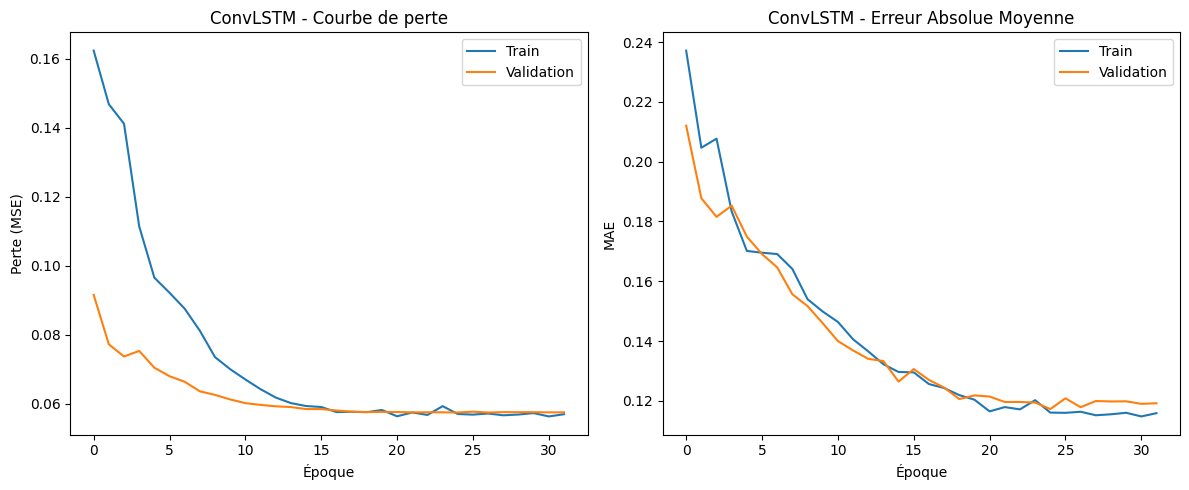

In [30]:
# Évaluation du modèle
print("Évaluation du modèle ConvLSTM...")
convlstm_eval = convlstm_model.evaluate([X_val, date_features_val], y_val, batch_size=BATCH_SIZE, verbose=1)
print(f"Résultats de l'évaluation - ConvLSTM:")
print(f"  Loss: {convlstm_eval[0]:.4f}")
print(f"  MAE: {convlstm_eval[1]:.4f}")

# Sauvegarde du modèle
convlstm_model.save(f"{MODEL_SAVE_PATH}_ConvLSTM.keras")
print(f"Modèle ConvLSTM sauvegardé à {MODEL_SAVE_PATH}_ConvLSTM.keras")

# Visualisation de l'apprentissage
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(convlstm_history.history['loss'], label='Train')
plt.plot(convlstm_history.history['val_loss'], label='Validation')
plt.title('ConvLSTM - Courbe de perte')
plt.xlabel('Époque')
plt.ylabel('Perte (MSE)')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(convlstm_history.history['mae'], label='Train')
plt.plot(convlstm_history.history['val_mae'], label='Validation')
plt.title('ConvLSTM - Erreur Absolue Moyenne')
plt.xlabel('Époque')
plt.ylabel('MAE')
plt.legend()

plt.tight_layout()
plt.savefig(os.path.join(CHECKPOINT_DIR, 'convlstm_training_curves.png'))
plt.show()

In [33]:
# Calcul d'une mesure d'exactitude pour le modèle
print("Calcul de l'exactitude du modèle ConvLSTM...")

# Faire des prédictions sur l'ensemble de validation
y_pred = convlstm_model.predict([X_val, date_features_val], batch_size=BATCH_SIZE, verbose=1)

# Définir un seuil d'erreur acceptable (par exemple, 10% de l'écart-type des données)
threshold = 0.4 * np.std(y_val)

# Calculer l'erreur absolue entre les prédictions et les valeurs réelles
errors = np.abs(y_pred - y_val)

# Calculer le pourcentage de prédictions dont l'erreur est inférieure au seuil
accuracy = np.mean(errors < threshold) * 100

print(f"Exactitude du modèle ConvLSTM (seuil d'erreur = {threshold:.4f}):")
print(f"  {accuracy:.2f}% des prédictions ont une erreur inférieure au seuil")

Calcul de l'exactitude du modèle ConvLSTM...
35/35 ━━━━━━━━━━━━━━━━━━━━ 4s 102ms/step
Exactitude du modèle ConvLSTM (seuil d'erreur = 0.1979):
  83.99% des prédictions ont une erreur inférieure au seuil


In [ ]:
import numpy as np
import tensorflow as tf
import os
import glob
import re
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import gc
from sklearn.preprocessing import MinMaxScaler # Utilisé pour charger le scaler
import joblib # Pour charger le scaler sauvegardé

# --- Fonctions fournies (légèrement adaptées pour la prédiction) ---

def extract_date_from_filename(filename):
    """Extraire la date du nom de fichier (ex: Rainf_20190101.png)"""
    pattern = r'Rainf_(\d{8})\.png'
    match = re.search(pattern, os.path.basename(filename))
    if match:
        date_str = match.group(1)
        try:
            return datetime.strptime(date_str, '%Y%m%d')
        except ValueError:
            return None
    return None

def date_to_features(date_obj):
    """Convertit une date en caractéristiques temporelles utilisables par le modèle"""
    if isinstance(date_obj, str):
        try:
            # Essayer plusieurs formats si nécessaire
            date = datetime.strptime(date_obj, '%Y-%m-%d')
        except ValueError:
            try:
                date = datetime.strptime(date_obj, '%Y%m%d')
            except ValueError:
                print(f"Erreur: Format de date non reconnu pour '{date_obj}'")
                return None # Gérer l'erreur de format
    elif isinstance(date_obj, datetime):
        date = date_obj
    else:
        print(f"Erreur: Type de date non supporté '{type(date_obj)}'")
        return None

    year = date.year
    month = date.month
    day = date.day
    day_of_year = date.timetuple().tm_yday

    month_sin = np.sin(2 * np.pi * month / 12)
    month_cos = np.cos(2 * np.pi * month / 12)
    day_sin = np.sin(2 * np.pi * day_of_year / 365.25) # Utiliser 365.25 pour les années bissextiles
    day_cos = np.cos(2 * np.pi * day_of_year / 365.25)

    # Normaliser l'année (exemple simple, à ajuster si nécessaire basé sur l'entraînement)
    # Si vous avez normalisé l'année pendant l'entraînement, appliquez la même méthode ici.
    # Sinon, vous pouvez l'utiliser telle quelle ou la normaliser sur une plage attendue.
    # Exemple: normaliser entre 2000 et 2030 -> (year - 2000) / 30
    normalized_year = (year - 2015) / 10 # Exemple: centré autour de 2015 sur 10 ans

    # Normaliser month, day, day_of_year (exemple simple, ajuster si fait différemment à l'entraînement)
    norm_month = (month - 1) / 11
    norm_day = (day - 1) / 30
    norm_doy = (day_of_year - 1) / 364.25

    # Retourner 8 caractéristiques. Assurez-vous que l'ordre et la normalisation
    # correspondent EXACTEMENT à ce qui a été utilisé pour l'entraînement.
    # L'exemple ci-dessous utilise les caractéristiques cycliques et normalisées.
    # Adaptez si vous avez utilisé year, month, day, day_of_year directement.
    return np.array([
        normalized_year, # Ou 'year' si non normalisé à l'entraînement
        norm_month,      # Ou 'month'
        norm_day,        # Ou 'day'
        norm_doy,        # Ou 'day_of_year'
        month_sin,
        month_cos,
        day_sin,
        day_cos
    ]).astype(np.float32)


def load_preprocess_scale_sequence(target_date, data_dir, seq_len, img_height, img_width, scaler):
    """
    Charge, pré-traite et normalise la séquence d'images réelles
    nécessaire pour la prédiction à une date donnée.
    """
    sequence_images = []
    sequence_dates = []

    # Déterminer les dates de la séquence d'entrée
    current_date = target_date
    for _ in range(seq_len):
        # Trouver la date précédente (attention aux jours manquants potentiels)
        # Ici, on suppose des données journalières continues pour simplifier.
        # Une logique plus robuste chercherait le fichier existant le plus proche.
        current_date -= timedelta(days=1)
        sequence_dates.append(current_date)

    sequence_dates.reverse() # Mettre dans l'ordre chronologique

    print(f"Recherche des images pour la séquence se terminant le {sequence_dates[-1].strftime('%Y-%m-%d')}")

    # Charger les images pour ces dates
    loaded_count = 0
    for date_obj in sequence_dates:
        date_str = date_obj.strftime('%Y%m%d')
        filename = f"Rainf_{date_str}.png"
        img_path = os.path.join(data_dir, filename)

        if os.path.exists(img_path):
            try:
                img = plt.imread(img_path)
                if len(img.shape) > 2 and img.shape[2] > 1:
                    img = np.mean(img, axis=2) # Convertir en niveaux de gris

                # Redimensionner
                img_resized = tf.image.resize(img[:,:,np.newaxis], [img_height, img_width]).numpy()
                sequence_images.append(img_resized)
                loaded_count += 1
            except Exception as e:
                print(f"Erreur de chargement/redimensionnement de {img_path}: {e}")
                return None # Erreur critique si une image manque ou est corrompue
        else:
            print(f"Erreur: Fichier image manquant pour la date {date_str} : {img_path}")
            return None # Ne peut pas faire de prédiction si une image manque

    if loaded_count != seq_len:
        print(f"Erreur: N'a pu charger que {loaded_count}/{seq_len} images pour la séquence.")
        return None

    # Convertir en array numpy
    X_seq = np.array(sequence_images).astype(np.float32)

    # Normaliser en utilisant le scaler chargé
    X_seq_reshaped = X_seq.reshape(seq_len, -1)
    try:
        X_seq_scaled_reshaped = scaler.transform(X_seq_reshaped) # Utiliser transform() !
    except Exception as e:
        print(f"Erreur lors de l'application du scaler.transform : {e}")
        print("Assurez-vous que le scaler chargé est le bon et que les données ont le bon format.")
        return None
    X_seq_scaled = X_seq_scaled_reshaped.reshape(seq_len, img_height, img_width, 1)

    print(f"Séquence chargée et normalisée avec succès. Shape: {X_seq_scaled.shape}")
    return X_seq_scaled

# --- Configuration ---
DATA_DIR = r'E:\kraya_espri_3eme\Sem2\projet\GitHub\Water-Scarcity\data\Rainf' # Adaptez ce chemin !
CHECKPOINT_DIR = './checkpoints' # Adaptez si nécessaire
MODEL_FILENAME = 'PotEvap_convlstm_best.keras' # Adaptez si nécessaire
SCALER_FILENAME = 'scaler_rainf.pkl' # Nom du fichier scaler sauvegardé (adaptez !)

MODEL_PATH = os.path.join(CHECKPOINT_DIR, MODEL_FILENAME)
SCALER_PATH = os.path.join(CHECKPOINT_DIR, SCALER_FILENAME) # Sauvegardez/chargez depuis le même endroit

# Date pour laquelle on veut commencer la prédiction
TARGET_PREDICTION_DATE_STR = '2020-12-25' # Mettez votre date cible ici !

# --- Paramètres du modèle (vérifiés à partir du summary) ---
SEQ_LENGTH = 30
IMG_HEIGHT = 128
IMG_WIDTH = 256
PRED_STEPS = 7
DATE_FEATURES_SIZE = 8 # Doit correspondre à la sortie de date_to_features
NUM_PREDICTIONS = 1

# --- Chargement du modèle et du scaler ---
print("Chargement du modèle...")
try:
    convlstm_model = tf.keras.models.load_model(MODEL_PATH)
    print(f"Modèle chargé depuis : {MODEL_PATH}")
    # convlstm_model.summary() # Décommentez pour vérifier l'architecture
except Exception as e:
    print(f"Erreur critique lors du chargement du modèle depuis {MODEL_PATH}: {e}")
    exit()

print("\nChargement du scaler...")
try:
    scaler = joblib.load(SCALER_PATH)
    print(f"Scaler chargé depuis : {SCALER_PATH}")
except FileNotFoundError:
    print(f"ERREUR: Fichier scaler non trouvé à {SCALER_PATH}")
    print("Assurez-vous d'avoir sauvegardé le scaler pendant l'entraînement et que le chemin est correct.")
    exit()
except Exception as e:
    print(f"Erreur lors du chargement du scaler : {e}")
    exit()

# --- Préparation des données d'entrée réelles ---
print(f"\nPréparation des données pour la prédiction commençant le {TARGET_PREDICTION_DATE_STR}...")

# Convertir la date cible en objet datetime
try:
    target_date_obj = datetime.strptime(TARGET_PREDICTION_DATE_STR, '%Y-%m-%d')
except ValueError:
    print(f"Erreur: Format de date invalide pour TARGET_PREDICTION_DATE_STR: '{TARGET_PREDICTION_DATE_STR}'. Utilisez 'YYYY-MM-DD'.")
    exit()

# 1. Obtenir la séquence d'images prétraitée et normalisée
real_input_sequence_processed = load_preprocess_scale_sequence(
    target_date_obj, DATA_DIR, SEQ_LENGTH, IMG_HEIGHT, IMG_WIDTH, scaler
)

if real_input_sequence_processed is None:
    print("Erreur lors de la préparation de la séquence d'images. Arrêt.")
    exit()

# Ajouter la dimension du batch
real_input_sequence = np.expand_dims(real_input_sequence_processed, axis=0)

# 2. Obtenir les caractéristiques de date pour la date cible
real_input_date_features_processed = date_to_features(target_date_obj)

if real_input_date_features_processed is None:
    print("Erreur lors de la préparation des caractéristiques de date. Arrêt.")
    exit()
if len(real_input_date_features_processed) != DATE_FEATURES_SIZE:
     print(f"Erreur: La fonction date_to_features a retourné {len(real_input_date_features_processed)} caractéristiques, mais le modèle en attend {DATE_FEATURES_SIZE}.")
     exit()

# Ajouter la dimension du batch
real_input_date_features = np.expand_dims(real_input_date_features_processed, axis=0)

# --- Vérification finale des dimensions ---
expected_seq_shape = (NUM_PREDICTIONS, SEQ_LENGTH, IMG_HEIGHT, IMG_WIDTH, 1)
expected_date_shape = (NUM_PREDICTIONS, DATE_FEATURES_SIZE)

if real_input_sequence.shape != expected_seq_shape:
    print(f"ERREUR: Shape de la séquence d'entrée incorrecte ! Attendu: {expected_seq_shape}, Obtenu: {real_input_sequence.shape}")
    exit()
if real_input_date_features.shape != expected_date_shape:
    print(f"ERREUR: Shape des caractéristiques de date incorrecte ! Attendu: {expected_date_shape}, Obtenu: {real_input_date_features.shape}")
    exit()

print(f"\nShape de l'input séquence réel prêt: {real_input_sequence.shape}")
print(f"Shape de l'input date réel prêt: {real_input_date_features.shape}")

# --- Faire la prédiction ---
print("\nLancement de la prédiction...")
try:
    predicted_output = convlstm_model.predict([real_input_sequence, real_input_date_features])
    print("Prédiction terminée.")
except Exception as e:
    print(f"Erreur lors de l'appel à model.predict() : {e}")
    exit()

# --- Analyser la sortie ---
print(f"\nShape de la sortie prédite: {predicted_output.shape}")
expected_output_shape = (NUM_PREDICTIONS, PRED_STEPS, IMG_HEIGHT, IMG_WIDTH, 1)

if predicted_output.shape == expected_output_shape:
    print("La forme de la sortie est correcte !")

    # IMPORTANT: La sortie est normalisée (entre 0 et 1).
    # Pour obtenir les valeurs réelles, vous devez appliquer l'inverse de la transformation du scaler.
    predicted_output_reshaped = predicted_output.reshape(NUM_PREDICTIONS * PRED_STEPS, -1)
    try:
        predicted_output_inverse_reshaped = scaler.inverse_transform(predicted_output_reshaped)
        predicted_output_inverse = predicted_output_inverse_reshaped.reshape(NUM_PREDICTIONS, PRED_STEPS, IMG_HEIGHT, IMG_WIDTH, 1)
        print("Sortie dénormalisée avec succès.")

        # Vous pouvez maintenant utiliser 'predicted_output_inverse' pour la visualisation ou l'analyse
        # Exemple de visualisation de la première prédiction dénormalisée
        # import matplotlib.pyplot as plt
        # fig, axes = plt.subplots(1, PRED_STEPS, figsize=(20, 4))
        # fig.suptitle(f'Prédictions Dénormalisées pour {TARGET_PREDICTION_DATE_STR}')
        # vmin = np.min(predicted_output_inverse[0]) # Min/Max pour l'échelle de couleur
        # vmax = np.max(predicted_output_inverse[0])
        # for i in range(PRED_STEPS):
        #     ax = axes[i] if PRED_STEPS > 1 else axes
        #     img_data = predicted_output_inverse[0, i, :, :, 0] # Prend la i-ème image prédite dénormalisée
        #     im = ax.imshow(img_data, cmap='viridis', vmin=vmin, vmax=vmax) # Adaptez la colormap
        #     pred_date = target_date_obj + timedelta(days=i)
        #     ax.set_title(f"Step +{i+1}\n{pred_date.strftime('%Y-%m-%d')}")
        #     ax.axis('off')
        # plt.colorbar(im, ax=axes.ravel().tolist(), shrink=0.6)
        # plt.tight_layout(rect=[0, 0.03, 1, 0.95]) # Ajuster pour le titre global
        # plt.show()

    except Exception as e:
        print(f"Erreur lors de l'application du scaler.inverse_transform : {e}")
        print("Impossible de dénormaliser la sortie.")

else:
    print(f"ERREUR: La forme de la sortie est {predicted_output.shape}, mais la forme attendue était {expected_output_shape}")

print("\nScript de prédiction terminé.")

In [ ]:
fig, axes = plt.subplots(1, PRED_STEPS, figsize=(20, 4))
fig.suptitle(f'Prédictions Dénormalisées pour {TARGET_PREDICTION_DATE_STR}')
vmin = np.min(predicted_output_inverse[0]) # Min/Max pour l'échelle de couleur
vmax = np.max(predicted_output_inverse[0])
for i in range(PRED_STEPS):
    ax = axes[i] if PRED_STEPS > 1 else axes
    img_data = predicted_output_inverse[0, i, :, :, 0] # Prend la i-ème image prédite dénormalisée
    im = ax.imshow(img_data, cmap='viridis', vmin=vmin, vmax=vmax) # Adaptez la colormap
    pred_date = target_date_obj + timedelta(days=i)
    ax.set_title(f"Step +{i+1}\n{pred_date.strftime('%Y-%m-%d')}")
    ax.axis('off')
plt.colorbar(im, ax=axes.ravel().tolist(), shrink=0.6)
plt.tight_layout(rect=[0, 0.03, 1, 0.95]) # Ajuster pour le titre global
plt.show()